In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import logging


from diffusers import SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler
from transformers import CLIPTextModelWithProjection, CLIPTokenizer, T5EncoderModel, T5TokenizerFast

from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3, free_memory


from text_embed import encode_prompt, get_precomputed_tensors
from datasets import FillDataset
from sd3 import SD3CNModel, get_sigmas
from controlnext import ControlNeXtModel

2024-11-05 17:07:16.310828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 17:07:16.310874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 17:07:16.312063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 17:07:16.318600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 17:07:17.025321: W tensorflow/compiler/tf2

In [3]:
device = 'cuda:0'

In [4]:
# transformer = SD3CNModel.from_pretrained(
#     "stabilityai/stable-diffusion-3-medium-diffusers",
#     subfolder="transformer",
#     torch_dtype=torch.float16).to(device)
transformer = SD3CNModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",).to(device)

In [5]:
vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26").to(device)

In [6]:
noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", subfolder="scheduler"
)
noise_scheduler_copy = copy.deepcopy(noise_scheduler)

In [9]:
tensor_list = get_precomputed_tensors(device=device)
        
pixel_list = [x['img'] for x in tensor_list]
hint_list = [x['hint'] for x in tensor_list]
prompt_embed_list = [x['prompt_embeds'] for x in tensor_list]
pooled_prompt_embed_list = [x['pooled_prompt_embeds'] for x in tensor_list]

In [10]:
model_input = vae.encode(pixel_list[0]).latent_dist.sample()
model_input = (model_input - vae.config.shift_factor) * vae.config.scaling_factor

In [11]:
# control_input = vae.encode(hint_list[0]).latent_dist.sample()
# control_input = (control_input - vae.config.shift_factor) * vae.config.scaling_factor

In [12]:
# Sample noise that we'll add to the latents
noise = torch.randn_like(model_input)
bsz = model_input.shape[0]
# Sample a random timestep for each image
# for weighting schemes where we sample timesteps non-uniformly
u = compute_density_for_timestep_sampling(
    weighting_scheme="logit_normal",
    batch_size=1,
    logit_mean=0,
    logit_std=1,
    mode_scale=1.29,
)

In [13]:
indices = (u * noise_scheduler_copy.config.num_train_timesteps).long()
timesteps = noise_scheduler_copy.timesteps[indices].to(device=model_input.device)

# Add noise according to flow matching.
# zt = (1 - texp) * x + texp * z1
sigmas = get_sigmas(timesteps, noise_scheduler_copy, n_dim=model_input.ndim, dtype=model_input.dtype, device=device)
noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

In [14]:
control_next_model = ControlNeXtModel(upscale_dim=1536).to(device)
# control_next_model = ControlNeXtModel().to(device)

res = control_next_model(hint_list[0], timesteps)
control_out = res['output']

/home/sj/diffusers/src/diffusers/models/downsampling.py:135: FutureWarning: `scale` is deprecated and will be removed in version 1.0.0. The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`.
  deprecate("scale", "1.0.0", deprecation_message)


In [15]:
control_out.shape

torch.Size([1, 1024, 1536])

In [16]:
# Get the text embedding for conditioning
prompt_embeds = prompt_embed_list[0].to(device)
pooled_prompt_embeds = pooled_prompt_embed_list[0].to(device)



In [17]:
print(noisy_model_input.dtype, noisy_model_input.device)
print(timesteps.dtype, timesteps.device)
print(prompt_embeds.dtype, prompt_embeds.device)
print(pooled_prompt_embeds.dtype, pooled_prompt_embeds.device)


torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0
torch.float32 cuda:0


In [18]:
# Predict the noise residual
model_pred = transformer(
    hidden_states=noisy_model_input,
    timestep=timesteps,
    encoder_hidden_states=prompt_embeds,
    pooled_projections=pooled_prompt_embeds,
    controlnet_hidden_states=control_out,
    return_dict=False,
)[0]

In [31]:
# Predict the noise residual
model_pred = transformer(
    # hidden_states=noisy_model_input,
    timestep=timesteps,
    encoder_hidden_states=prompt_embeds,
    pooled_projections=pooled_prompt_embeds,
    controlnet_hidden_states=control_out,
    return_dict=False,
)[0]

TypeError: SD3CNModel.forward() missing 1 required positional argument: 'hidden_states'

In [20]:
model_pred.shape

torch.Size([1, 16, 64, 64])

In [29]:
decoded = vae.decode(model_pred).sample.cpu().detach().squeeze().permute(1,2,0)
min_val = decoded.min()
max_val = decoded.max()
decoded = (decoded - min_val) / (max_val - min_val)

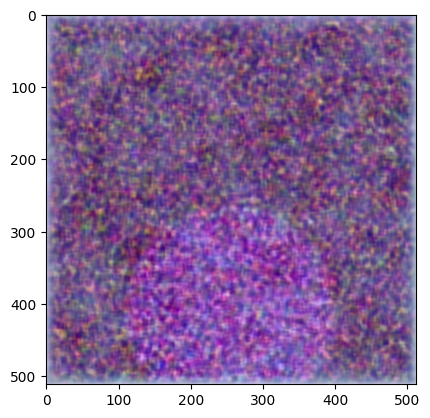

In [30]:
plt.imshow(decoded)